Testing reliability of anatomical signals in relation to number of acquisitions

In [1]:
import nibabel as nib
import os
from brainsss2.imgmath import imgmath
import ants
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
basedir = '/data/brainsss/processed/fly_001/anat_0/imaging/'

origfile = os.path.join(basedir, 'anatomy_channel_1.nii')
meanfile = os.path.join(basedir, 'anatomy_channel_1_mean.nii')
if not os.path.exists(meanfile):
    meanfile = imgmath(origfile, 'mean')

meanimg = nib.load(meanfile)

# get mask to select voxels
maskfile = meanfile.replace('_mean.nii', '_mask.nii')
if not os.path.exists(maskfile):
    meanimg_ants = ants.image_read(meanfile)
    mask_ants = ants.get_mask(meanimg_ants,
        low_thresh=None,
        cleanup=4)
    mask_img = mask_ants.to_nibabel()
    mask_img.header.set_data_dtype('uint8')
    mask_img.header.set_zooms(meanimg.header.get_zooms())
    mask_img.header.set_qform(meanimg.header.get_qform())
    mask_img.header.set_sform(meanimg.header.get_sform())
    mask_img.header.set_xyzt_units('mm', 'sec')
    mask_img.to_filename(maskfile)
else:
    mask_img = nib.load(maskfile)



In [3]:
# compute reliability of random samples of varying size

origimg = nib.load(origfile)

def get_flattened_data(img, mask, start, length):
    data = img.dataobj[:, :, :,start:(start + length)]
    meandata = data.mean(axis=-1)
    maskdata = mask_img.get_fdata().astype("int")
    return(meandata[maskdata==1])

if 1:
    # get two sets of data
    starts = [0, int(origimg.shape[-1]/2)]
    cc = {}
    for length in range(1,50):
        data_vec = {}
        for i, start in enumerate(starts):
            data_vec[i] = get_flattened_data(
                origimg, mask_img, start, length)
        cc[length] = np.corrcoef(data_vec[0], data_vec[1])[0,1]
        # print(f'{length} {cc[length]}')

In [4]:

cc_df = pd.DataFrame(cc.items(), columns=['length', 'cc'])

Text(0, 0.5, 'correlation coefficient')

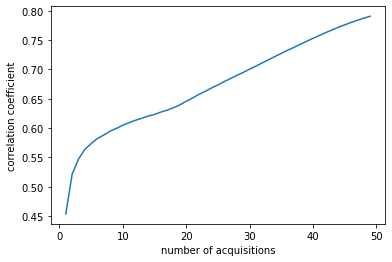

In [5]:
plt.plot(cc_df.length, cc_df.cc)
plt.xlabel('number of acquisitions')
plt.ylabel('correlation coefficient')